In [24]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [25]:
import cymetric as cym
from cymetric import filters
from cymetric import graphs
from cymetric import timeseries
from cymetric import tools
import graphviz
import sqlite3

In [26]:
import importlib.util

# Specify the path relative to the current notebook's directory
dep_spec = importlib.util.spec_from_file_location('deployment', '../scripts/deployment.py')
dep = importlib.util.module_from_spec(dep_spec)
dep_spec.loader.exec_module(dep)

tran_spec = importlib.util.spec_from_file_location('fuel_transactions', '../scripts/fuel_transactions.py')
tran = importlib.util.module_from_spec(tran_spec)
tran_spec.loader.exec_module(tran)

waste_spec = importlib.util.spec_from_file_location('waste', '../scripts/waste.py')
waste = importlib.util.module_from_spec(waste_spec)
waste_spec.loader.exec_module(waste)

# Cymetric

In [27]:
db = cym.dbopen('base_recycle_out.sqlite')
evaler = cym.Evaluator(db, write=False)

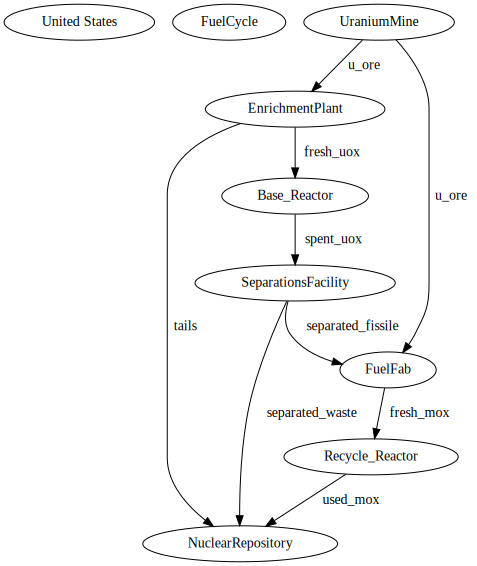

In [28]:
graphs.flow_graph(evaler, label='com')

In [29]:
reactor_list = ['Base_Reactor', 'Recycle_Reactor']
time = evaler.eval('TimeList')

Text(0, 0.5, 'Facilities [#]')

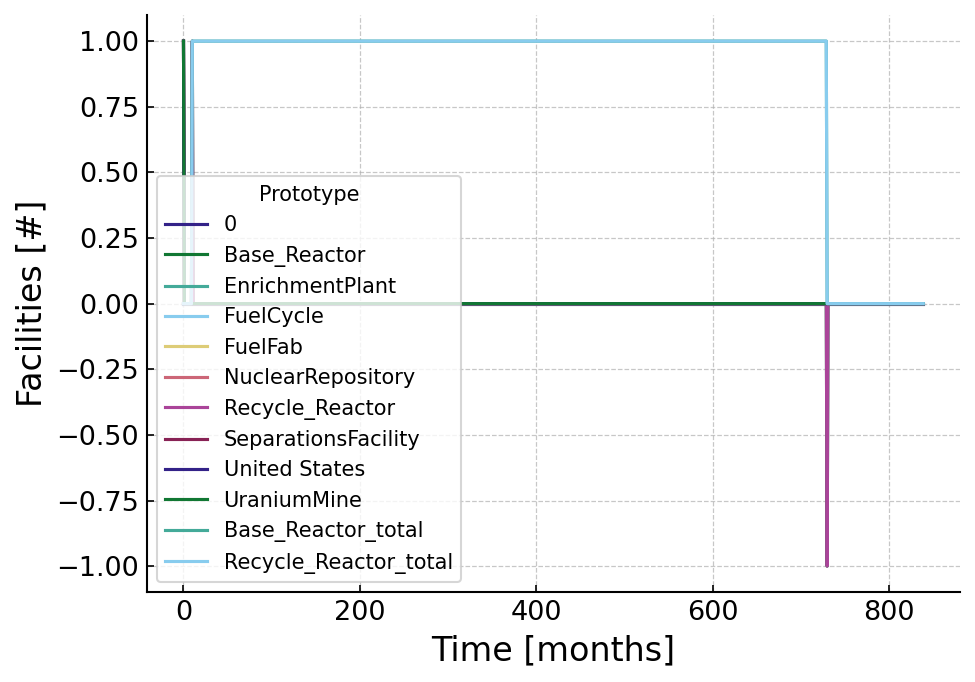

In [30]:
commission_by_prototype, commission_df = dep.comm_by_prototype(evaler, time)

decommission_by_prototype = dep.decom_by_prototype(evaler, commission_df, time)

deployment_by_prototype = dep.depl_by_prototype(commission_by_prototype, decommission_by_prototype, reactor_list)

deployment_by_prototype = dep.total_reactor(deployment_by_prototype, reactor_list)

deployment_by_prototype.plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Facilities [#]')

Text(0, 0.5, 'Reactors [#]')

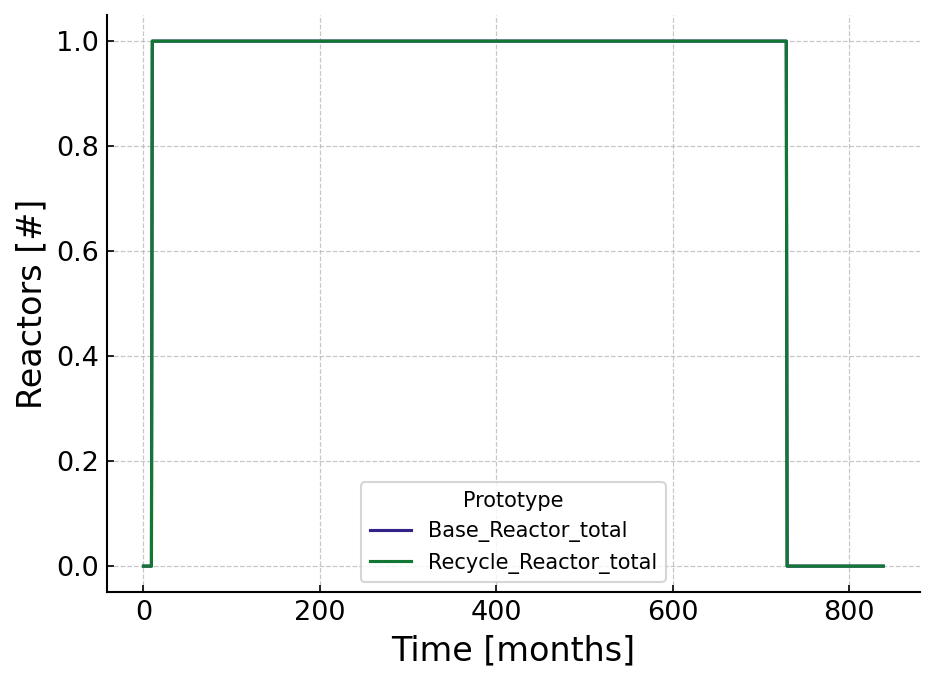

In [31]:
deployment_by_prototype[['Base_Reactor_total','Recycle_Reactor_total']].plot(use_index=True)
plt.xlabel('Time [months]')
plt.ylabel('Reactors [#]')

In [32]:
repository_waste = timeseries.transactions(evaler=evaler, receivers=['NuclearRepository'])

Text(0, 0.5, 'Mass of waste [kg]')

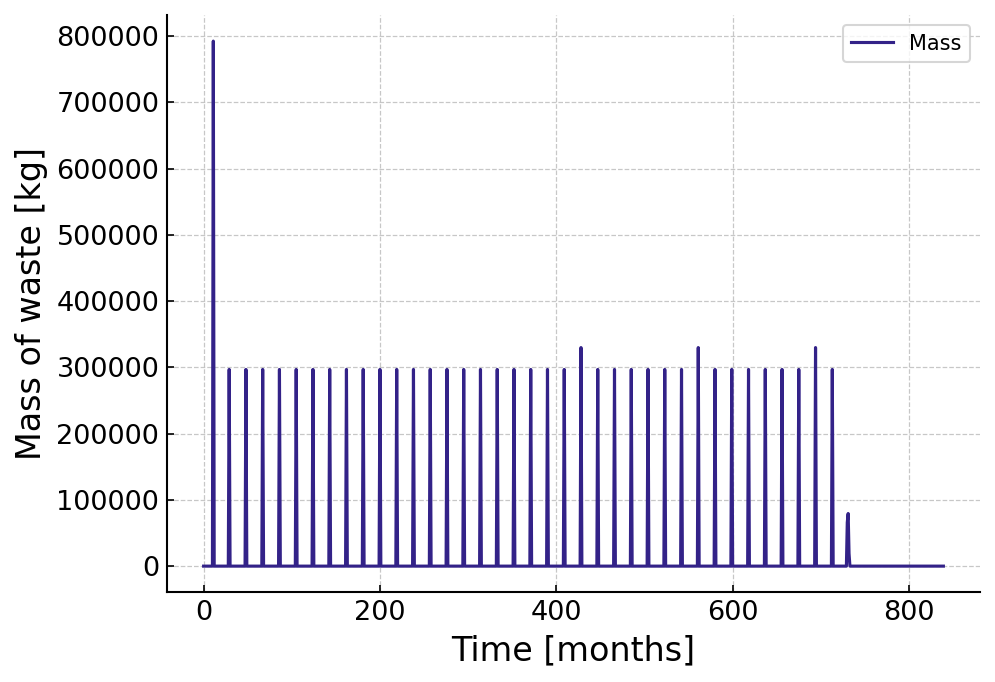

In [33]:
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

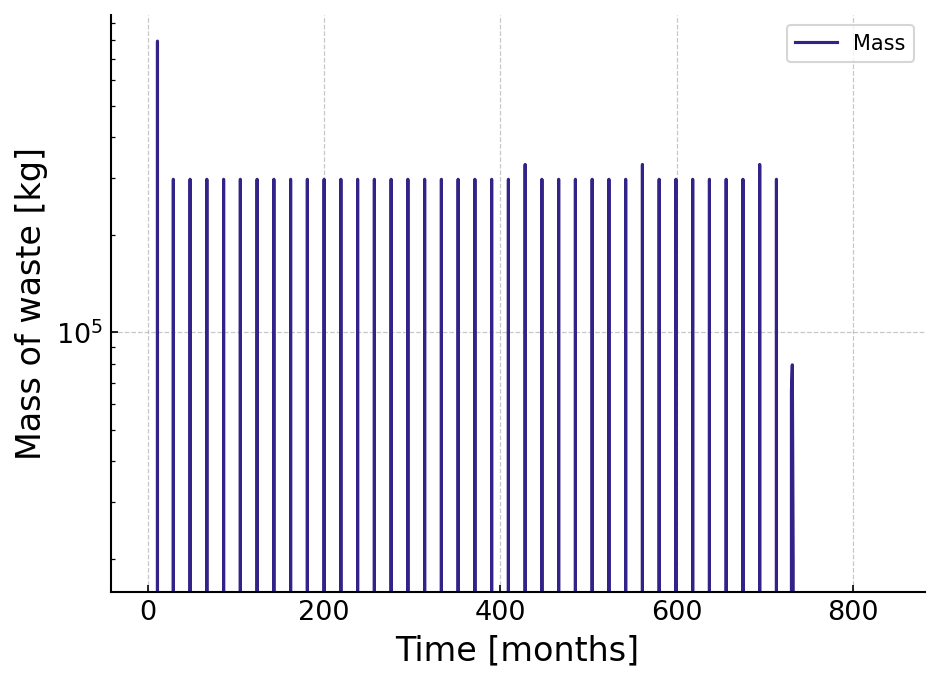

In [34]:
repository_waste.plot(x='Time', logy=True)
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

Text(0, 0.5, 'Mass of waste [kg]')

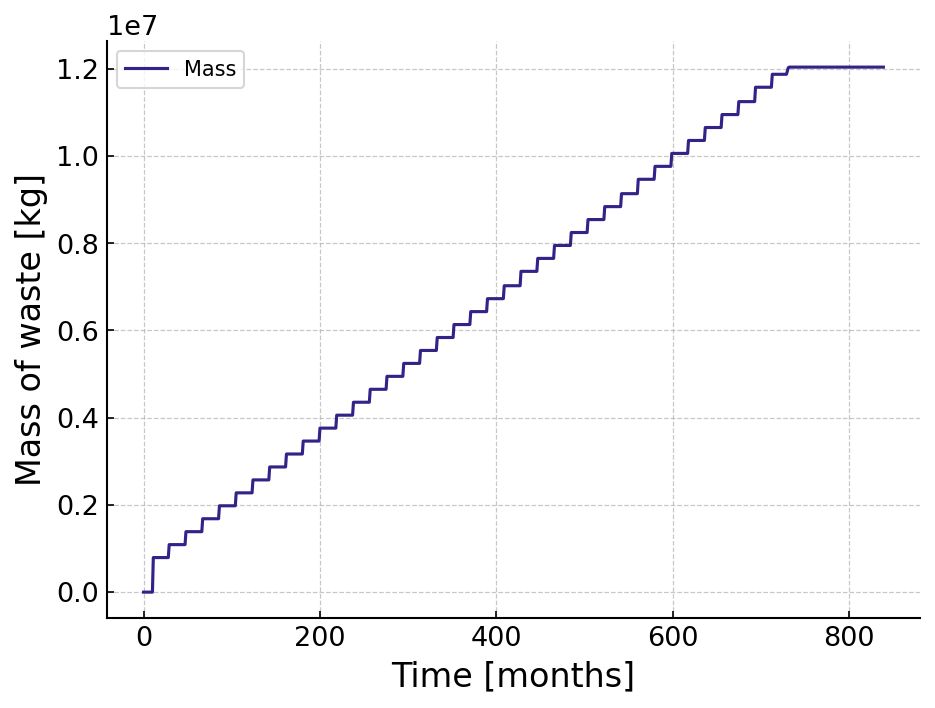

In [35]:
repository_waste['Mass'] = repository_waste['Mass'].cumsum()
repository_waste.plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of waste [kg]')

In [36]:
transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
transactions = transactions.rename(columns={'TimeCreated':'Time'})

fuels = ['uox','mox']

transactions = tran.spent_fuel_transactions(transactions, fuels)
transactions = tran.fresh_fuel_transactions(transactions, fuels)
transactions = tran.total_sp_fr_fuel(transactions, fuels)

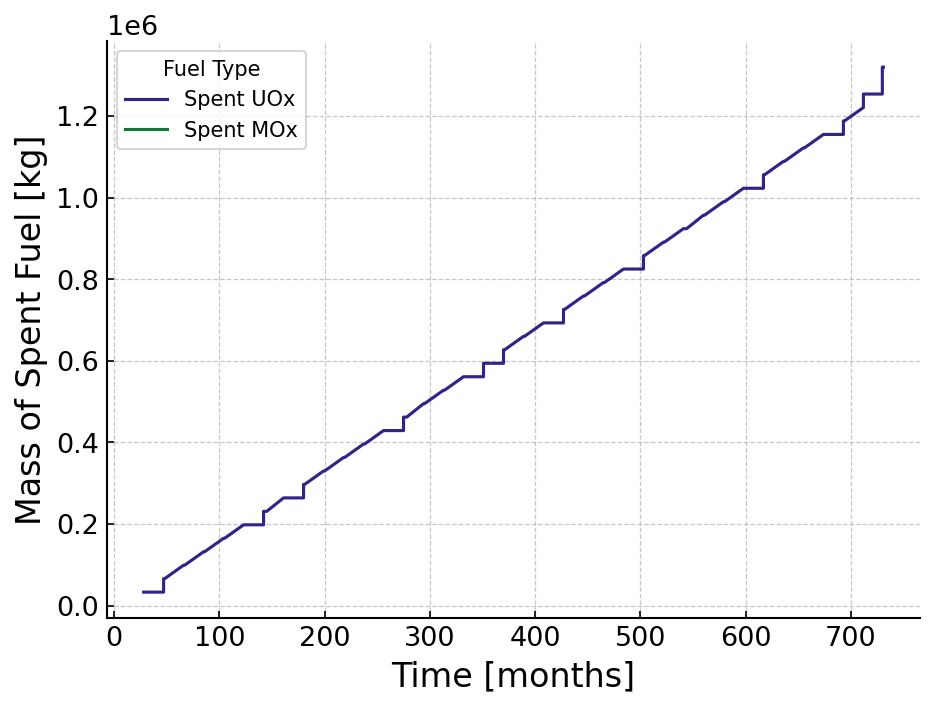

In [37]:
# Plotting cumulative fuel sent to reactors at each time step
transactions[['Time', 'spent_uox_total', 'spent_mox_total']].plot(x = 'Time')
# , style=['-.','-']
plt.xlabel('Time [months]')
plt.ylabel('Mass of Spent Fuel [kg]')

legend = plt.legend()
legend.get_texts()[0].set_text('Spent UOx')
legend.get_texts()[1].set_text('Spent MOx')
legend.set_title('Fuel Type')

Text(0, 0.5, 'Mass of U235 [kg]')

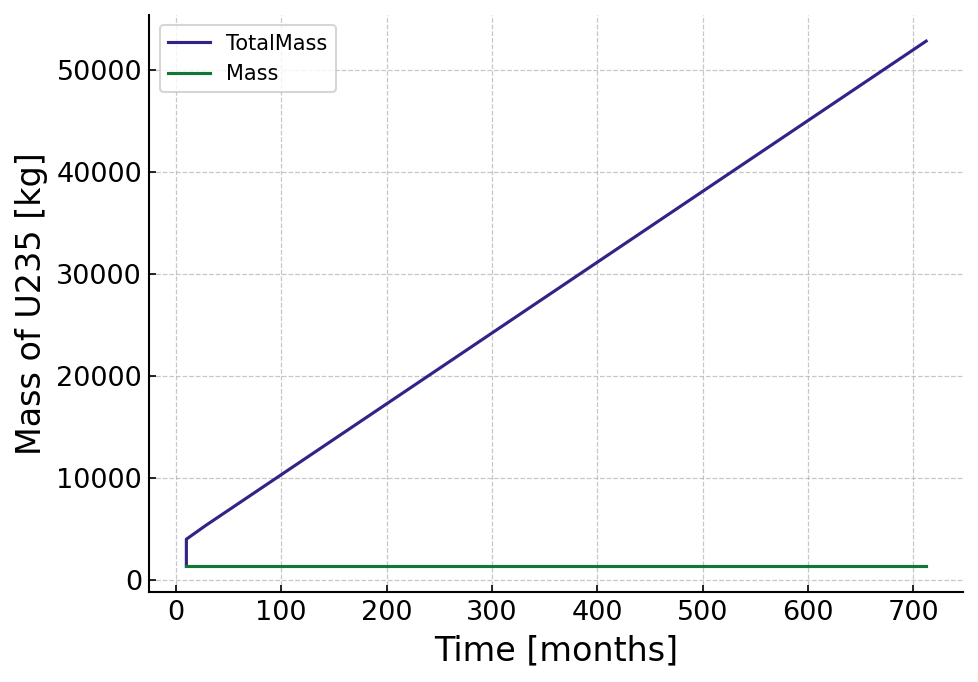

In [38]:
U235_mass = waste.transactions_nuc_built_in(evaler=evaler, receivers=['Base_Reactor'], commodities=['fresh_uox'], nucs=['92235'])

U235_mass['TotalMass'] = U235_mass['Mass'].cumsum()
U235_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of U235 [kg]')

In [44]:
Pu239_mass

,SimId,ResourceId,NucId,Mass,ReceiverId,ReceiverPrototype,SenderId,SenderPrototype,TransactionId,Commodity,Time,TotalMass


/home/nsryan/.local/lib/python3.11/site-packages/cymetric/tools.py:150: UserWarning: Empty  provided for ReceiverId key.
  warnings.warn(wng_msg, UserWarning)


Text(0, 0.5, 'Mass of Pu239 [kg]')

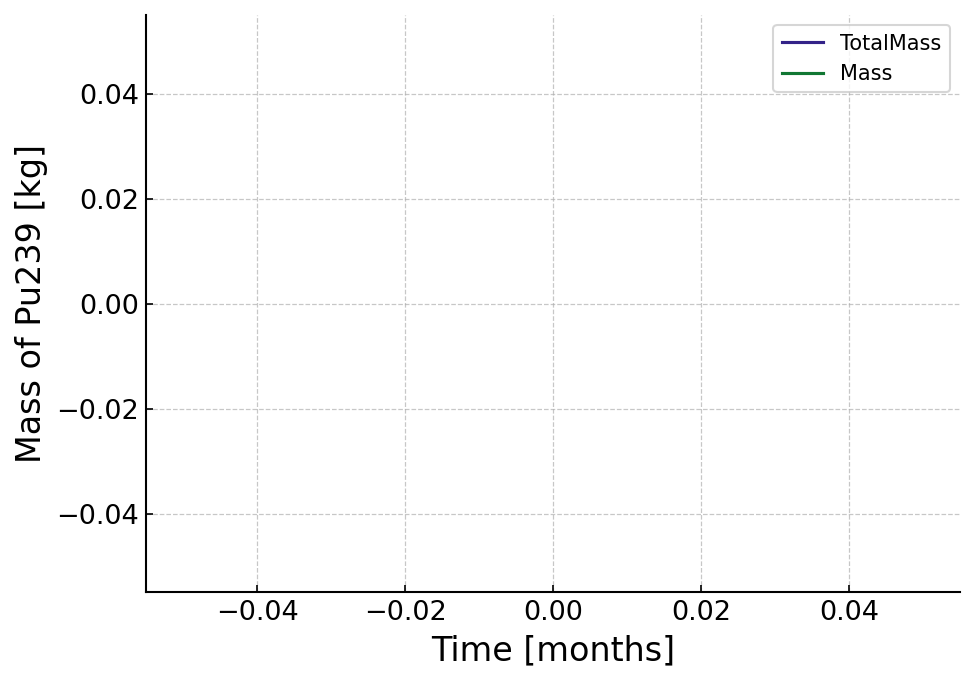

In [43]:
Pu239_mass = waste.transactions_nuc_built_in(evaler,receivers=['Storage'], commodities=['separated_waste','used_mox'], nucs=['94239'])

Pu239_mass['TotalMass'] = Pu239_mass['Mass'].cumsum()
Pu239_mass[['Time','TotalMass','Mass']].plot(x='Time')
plt.xlabel('Time [months]')
plt.ylabel('Mass of Pu239 [kg]')

# Sqlite Analysis
In this section, I will use basic sqlite to generate plots of the remaining data.

In [60]:
conn = sqlite3.connect('base_recycle_out.sqlite')

In [61]:
cursor = conn.cursor()

In [62]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
columns = cursor.fetchall()

In [63]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

# define variables for the start and end of the simulation
start_year = info_rows[0][2]
start_month= info_rows[0][3]
end_month = info_rows[0][4]

(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', '', 2020, 1, 840, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [64]:
# now we can add the rest of the dates from the simulation info
dates = pd.date_range(start=f'{start_year}-{start_month}-01', periods=end_month, freq='ME')

In [65]:
cursor.execute("SELECT * FROM DecomSchedule")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', 34, 730, 730)
(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', 35, 730, 730)


In [66]:
cursor.execute("SELECT * FROM BuildSchedule")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', 28, 'Base_Reactor', 0, 10)
(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', 28, 'Recycle_Reactor', 0, 10)


## Energy Production

In [67]:
# we will pull the decom schedule to see the ids and decomission date, to id the reactor
cursor.execute("SELECT * FROM DecomSchedule")
decom_rows = cursor.fetchall()

for row in decom_rows:
    print(row)

(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', 34, 730, 730)
(b'\x9d;-8\xd2\xc0B\xa4\xac1\xe2\xdd\xff5\xd5\xc1', 35, 730, 730)


In [68]:
# now we will pull the supplied power to get the amount of power from each reactor at every time step
cursor.execute("SELECT * FROM TimeSeriessupplyPOWER")
supply_rows = cursor.fetchall()

#for row in supply_rows:
#    print(row)

In [69]:
# create an empty dictionary that mirrors the format of the powersupply table
energy_supply = {
    'id':[],
    'time':[],
    'energy':[]
}

# now we will pull the power at each time step for each reactor
for row in range(len(supply_rows)):
    energy_supply['id'].append(str(supply_rows[row][1]))
    energy_supply['time'].append(supply_rows[row][2])
    energy_supply['energy'].append(supply_rows[row][3])

In [70]:
# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
energy_supply_df = pd.DataFrame.from_dict(energy_supply)

In [71]:
# we will turn the ids into columns of energy and make the index time
switch_energy_supply = energy_supply_df.pivot_table(index='time', columns='id', values='energy', fill_value=0)

# now we will add a total_energy column
switch_energy_supply['total_energy'] = switch_energy_supply.iloc[:,0:].sum(axis=1)

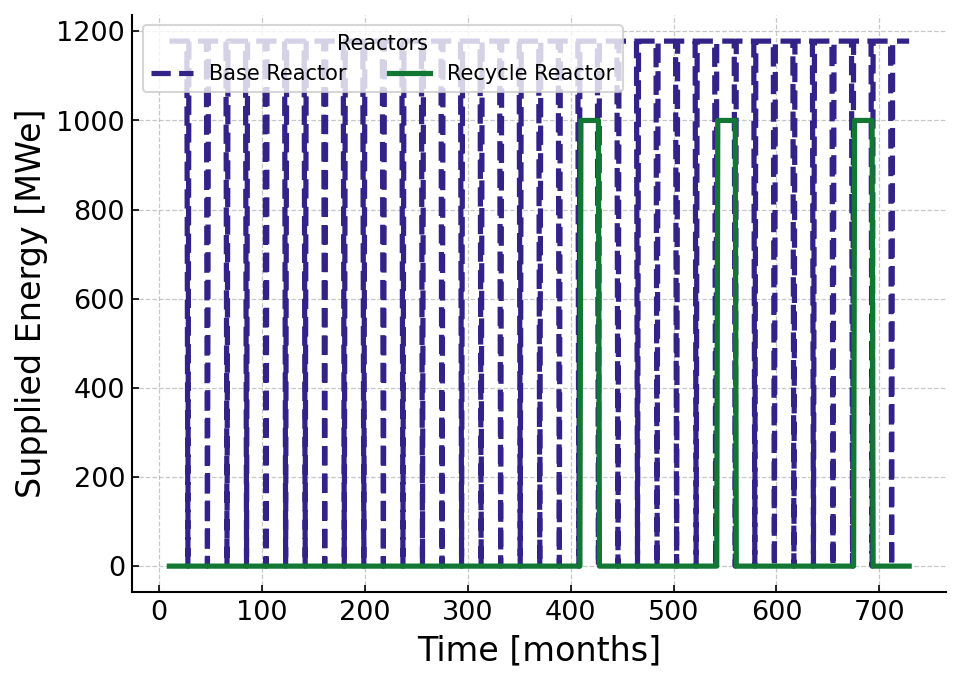

In [92]:
switch_energy_supply[['34','35']].plot(style=['--','-'], linewidth=2.5)
#switch_energy_supply[['53','total_energy']].plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend(loc="upper left",ncol=3)
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Recycle Reactor')
legend.set_title('Reactors')

In [46]:
simulation_energy_supply = pd.DataFrame(index=range(start_month,end_month), columns=switch_energy_supply.columns)
simulation_energy_supply = simulation_energy_supply.fillna(0)

for column in switch_energy_supply.columns:
    for time in range(min(switch_energy_supply.index), max(switch_energy_supply.index)):
        simulation_energy_supply.loc[time, column] = switch_energy_supply.loc[time, column]

/tmp/ipykernel_32202/2997257727.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  simulation_energy_supply = simulation_energy_supply.fillna(0)


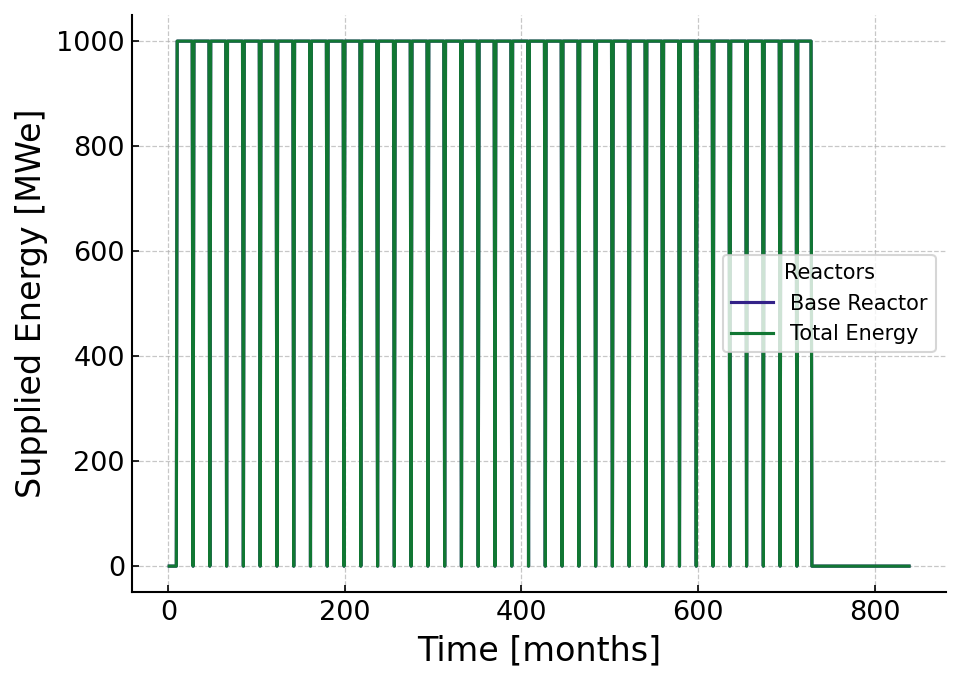

In [47]:
simulation_energy_supply.plot()
plt.xlabel('Time [months]')
plt.ylabel('Supplied Energy [MWe]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('Base Reactor')
legend.get_texts()[1].set_text('Total Energy')
legend.set_title('Reactors')

## SWU

In [52]:
cursor.execute("SELECT * FROM TimeSeriesEnrichmentSWU")
swu_rows = cursor.fetchall()


# for row in swu_rows:
#    print(row)

In [53]:
# create an empty dictionary that mirrors the format of the TimeSeriesEnrichmentSWU table
swu_supply = {
    'id':[],
    'Time':[],
    'SWU':[]
}

# now we will pull the swu at each time step for each facility
for row in range(len(swu_rows)):
    swu_supply['id'].append(str(swu_rows[row][1]))
    swu_supply['Time'].append(swu_rows[row][2])
    swu_supply['SWU'].append(swu_rows[row][3])

# make the dictionary into a pandas dataframe to match the type of the other data we've been working with
swu_supply_df = pd.DataFrame.from_dict(swu_supply)

In [54]:
# we will turn the ids into columns of energy and make the index time
switch_swu_supply = swu_supply_df.pivot_table(index='Time', columns='id', values='SWU', fill_value=0)

# now we will add a total_energy column
switch_swu_supply['total_swu'] = switch_swu_supply.iloc[:,0:].sum(axis=1)

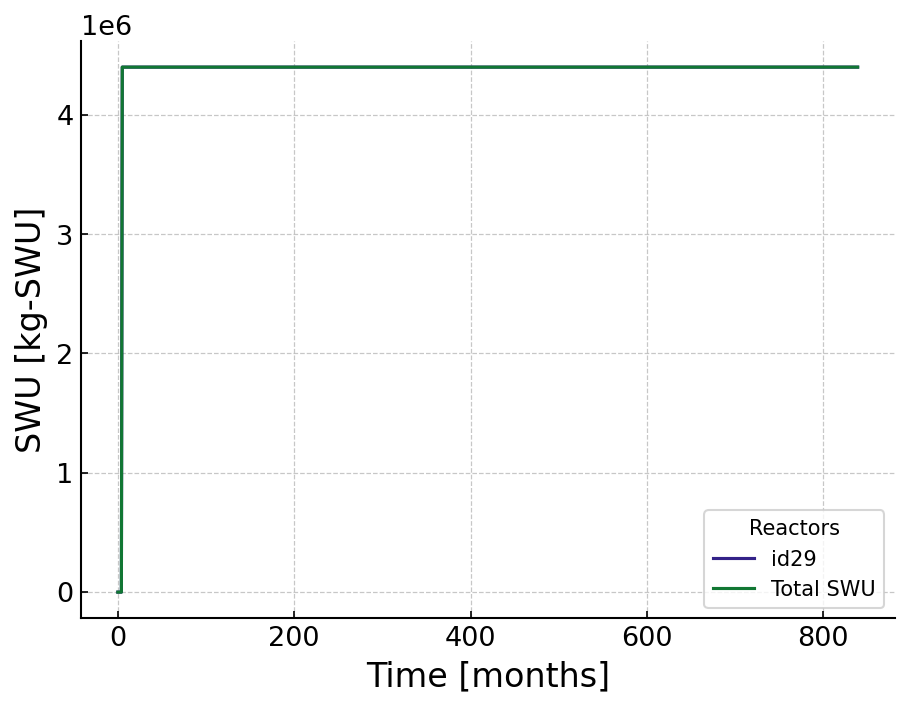

In [55]:
switch_swu_supply[['41','total_swu']].plot()
plt.xlabel('Time [months]')
plt.ylabel('SWU [kg-SWU]')

legend = plt.legend()
# here is where you can translate the ids to the reactor
legend.get_texts()[0].set_text('id41')
legend.get_texts()[1].set_text('Total SWU')
legend.set_title('Reactors')

# Graveyard

In [38]:
cursor.execute("SELECT * FROM TimeSeriesPower")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 10, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 11, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 12, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 13, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 14, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 15, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 17, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 18, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 19, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 20, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 21, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 80.0, '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 23, 80.0, '')
(b'\xdb\xb8nm\xb4 D`

In [39]:
cursor.execute("SELECT * FROM AgentStateInventories")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53523)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53529)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53531)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53533)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53535)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53537)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53598)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53600)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53602)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53604)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53606)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 29, 1500, 'inventory', 53665)
(b'\xdb\xb8nm\xb

In [40]:
cursor.execute("SELECT * FROM Prototypes")
rows = cursor.fetchall()
for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Xe_100_1', 14, ':cycamore:Reactor')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Sink', 15, ':cycamore:Sink')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Mine', 16, ':cycamore:Source')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'Enrichment', 17, ':cycamore:Enrichment')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'WetStorage', 18, ':cycamore:Storage')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'FuelCycle', 19, ':cycamore:DeployInst')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 'United States', 20, ':agents:NullRegion')


In [41]:
cursor.execute("SELECT * FROM ReactorEvents")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 10, 'LOAD', '7 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 10, 'CYCLE_START', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'TRANSMUTE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'CYCLE_END', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'DISCHARGE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'LOAD', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 16, 'CYCLE_START', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'TRANSMUTE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'CYCLE_END', '')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'DISCHARGE', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'LOAD', '1 assemblies')
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 35, 22, 'CYCLE_START', '')
(

In [42]:
cursor.execute("SELECT * FROM FieldTypes")
rows = cursor.fetchall()

for row in rows:
    print(row)

('InputFiles', 'SimId', 7)
('InputFiles', 'Data', 6)
('Info', 'SimId', 7)
('Info', 'Handle', 4)
('Info', 'InitialYear', 1)
('Info', 'InitialMonth', 1)
('Info', 'Duration', 1)
('Info', 'Seed', 1)
('Info', 'Stride', 1)
('Info', 'ParentSimId', 7)
('Info', 'ParentType', 4)
('Info', 'BranchTime', 1)
('Info', 'CyclusVersion', 4)
('Info', 'CyclusVersionDescribe', 4)
('Info', 'SqliteVersion', 4)
('Info', 'Hdf5Version', 4)
('Info', 'BoostVersion', 4)
('Info', 'LibXML2Version', 4)
('Info', 'CoinCBCVersion', 4)
('DecayMode', 'SimId', 7)
('DecayMode', 'Decay', 4)
('InfoExplicitInv', 'SimId', 7)
('InfoExplicitInv', 'RecordInventory', 0)
('InfoExplicitInv', 'RecordInventoryCompact', 0)
('TimeStepDur', 'SimId', 7)
('TimeStepDur', 'DurationSecs', 1)
('Epsilon', 'SimId', 7)
('Epsilon', 'GenericEpsilon', 3)
('Epsilon', 'ResourceEpsilon', 3)
('XMLPPInfo', 'SimId', 7)
('XMLPPInfo', 'LibXMLPlusPlusVersion', 4)
('SolverInfo', 'SimId', 7)
('SolverInfo', 'Solver', 4)
('SolverInfo', 'ExclusiveOrders', 0)
('Gre

In [43]:
cursor.execute("SELECT * FROM Info")
info_rows = cursor.fetchall()

for row in info_rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', '', 1965, 1, 1500, 20160212, 10000, b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'init', -1, '1.6.0', '1.6', '3.45.3', '1.14.3-', '1_85', '2.12.7', '-1')


In [44]:
cursor.execute("SELECT * FROM InfoExplicitInv")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 0)


In [45]:
cursor.execute("SELECT * FROM NextIds")
rows = cursor.fetchall()

for row in rows:
    print(row)

(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Agent', 35)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Transaction', 0)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Composition', 5)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'ResourceState', 1)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'ResourceObj', 1)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 0, 'Product', 1)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Agent', 36)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Transaction', 7999)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Composition', 1763)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'ResourceState', 105505)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'ResourceObj', 93627)
(b'\xdb\xb8nm\xb4 D`\xb3\xd3\xef\xe9\xaer\x1b\x12', 1500, 'Product', 1)


In [46]:
columns

[('FieldTypes',),
 ('InputFiles',),
 ('Info',),
 ('DecayMode',),
 ('InfoExplicitInv',),
 ('TimeStepDur',),
 ('Epsilon',),
 ('XMLPPInfo',),
 ('SolverInfo',),
 ('GreedySolverInfo',),
 ('Compositions',),
 ('Recipes',),
 ('AgentStateAgent',),
 ('AgentState_cycamore_ReactorInfo',),
 ('Prototypes',),
 ('AgentVersions',),
 ('AgentState_cycamore_SinkInfo',),
 ('AgentState_cycamore_SourceInfo',),
 ('AgentPosition',),
 ('AgentState_cycamore_EnrichmentInfo',),
 ('AgentState_cycamore_StorageInfo',),
 ('AgentState_cycamore_DeployInstInfo',),
 ('AgentState_agents_NullRegionInfo',),
 ('AgentEntry',),
 ('BuildSchedule',),
 ('Snapshots',),
 ('NextIds',),
 ('TimeSeriesdemandtails',),
 ('TimeSeriesdemandspent_uox_cooled',),
 ('TimeSeriessupplynat_u',),
 ('TimeSeriessupplytails',),
 ('TimeSeriessupplyfresh_uox',),
 ('Resources',),
 ('MaterialInfo',),
 ('ResCreators',),
 ('Transactions',),
 ('TimeSeriesEnrichmentSWU',),
 ('TimeSeriesEnrichmentFeed',),
 ('TimeSeriesdemandnat_u',),
 ('TimeSeriesdemandspent_u

In [47]:


# we'll make an empty dataframe based on this range, which we'll overwrite with the existing data
#simulation_energy_supply = pd.DataFrame(index=dates, columns=switch_energy_supply.columns)

# now we will combine the
#switch_energy_supply = switch_energy_supply.reindex(simulation_energy_supply.index)

#for col in switch_energy_supply.columns:
#    simulation_energy_supply[col] = switch_energy_supply[col].copy()

# now we can fill the missing values with 0 instead of NaN
#simulation_energy_supply = simulation_energy_supply.fillna(0)